In [1]:
from util import get_tickers
from pandas_datareader import data as pdr

In [2]:
tickers = get_tickers('dax_40.txt') + get_tickers('ftse_100.txt') + get_tickers('sp_500.txt') + get_tickers('omx_30.txt')

In [3]:
import random
import pandas as pd
random.seed(42)
# Assuming 'tickers' is your list of strings
#selected_tickers = random.sample(tickers, 50)

#selected_tickers = tickers

In [228]:
import re  # Regular expressions module

# Define the path to your file
file_path = 'data/recommended_gpt4.txt'

# Initialize an empty list to store ticker names
ticker_names = []

# Open and read the file
try:
    with open(file_path, 'r') as file:
        for line in file:
            # Use regular expression to find the ticker name in parentheses
            match = re.search(r'\((.*?)\)', line)
            if match:
                # If a match is found, extract the ticker name and add it to the list
                ticker_names.append(match.group(1))
except FileNotFoundError:
    print(f"The file at {file_path} was not found.")

# Print the list of ticker names
print(ticker_names)
selected_tickers = ticker_names

['AMZN', 'AAPL', 'MSFT', 'GOOGL', 'FB', 'BRK-A', 'JNJ', 'JPM', 'V', 'PG', 'INTC', 'KO', 'HD', 'MCD', 'NVDA', 'NFLX', 'BA', 'NKE', 'XOM', 'PFE', 'ADBE', 'CSCO', 'PEP', 'TSLA', 'DIS', 'GS', 'SBUX', 'CVX', 'IBM', 'MMM', 'ABT', 'AVGO', 'WFC', 'AXP', 'ORCL', 'UN', 'MA', 'MS', 'PYPL', 'UNH', 'BLK', 'WMT', 'COST', 'CAT', 'CRM', 'LMT', 'GM', 'F', 'KMB', 'TWLO', 'EL', 'T', 'BMY', 'LLY', 'DOW', 'DE', 'DAL', 'DD', 'GE', 'HPE', 'UPS', 'TXN', 'UBER', 'NEM', 'ZM', 'SPOT', 'WKHS', 'WU', 'WDAY', 'W', 'WBA', 'UA', 'TGT', 'SQ', 'WORK', 'SHOP', 'RCL', 'BOX', 'APRN', 'BIIB', 'BBY', 'BBBY', 'BAC', 'ADSK', 'AAL', 'A', 'AMD', 'ATVI', 'AZN', 'BIIB', 'RTX', 'ABB', 'BUD', 'TOT', 'SIEGY', 'UL', 'BABA', 'BIDU', 'TCEHY', 'TM', 'HSBA.L', 'BATS.L', 'GSK.L', 'BP.L', 'DGE.L', 'VOD.L', 'ULVR.L', 'RIO.L', 'RB.L', 'NG.L', 'BHP.L', 'AZN.L', 'AAL.L', 'LLOY.L', 'GLEN.L', 'BARC.L', 'ABF.L', 'AV.L', 'ERIC-B.ST', 'VOLV-B.ST', 'HM-B.ST', 'NDA-SE.ST', 'SEB-A.ST', 'SHB-A.ST', 'SAND.ST', 'ATCO-A.ST', 'INVE-B.ST', 'SCA-B.ST', 'SAAB

In [229]:
import random
import pandas as pd
random.seed(42)

#selected_tickers = random.sample(selected_tickers, 300)
len(selected_tickers)

143

In [230]:
period = 128  # trading days in half year


In [231]:
import os
import numpy as np
from datetime import timedelta

def nth_weekday_of_month(year, month, index, weekday):
  """
  Find the nth occurrence of a specific weekday in a given month.

  :param year: The year as an integer.
  :param month: The month as an integer (1-12).
  :param index: The index of the occurrence (1st, 2nd, 3rd, etc.)
  :param weekday: The day of the week as an integer where Monday is 1 and Sunday is 7.
  :return: The date of the nth weekday.
  """

  weekday = weekday - 1
  # Start at the beginning of the month
  first_day_of_month = pd.Timestamp(year=year, month=month, day=1)
  # Find the first occurrence of the specific weekday
  first_weekday = first_day_of_month + timedelta(days=((weekday - first_day_of_month.weekday()) + 7) % 7)
  
  # Add (index - 1) weeks to the first occurrence of the weekday
  nth_weekday = first_weekday + timedelta(weeks=index-1)
  return nth_weekday.day

def get_table_by_id_fred(id, path, n_features, 
                         start='1950-01-01', end="2024-01-01", if_log=True):
  print('start:', start, 'end:', end)
  feature_columns = []
  if path is None:
    df = pdr.get_data_fred(id, start=start)
  else:
    df = pd.read_csv(os.path.join(path, f'{id}.csv'), index_col='DATE', parse_dates=True)
    df = df[start:end]
  if if_log:
    df[f'log_{id}'] = np.log(df[id])
  
  n_days = [int(2**n) for n in range(n_features)]
  for n in n_days:
    if if_log:
      name = f'log_{id}_diff_{n}'
      df[name] = df[f'log_{id}'] - df[f'log_{id}'].shift(n)
    else:
      name = f'{id}_diff_{n}'
      df[name] = df[id] - df[id].shift(n)
    feature_columns.append(name)
  return df, feature_columns

def merge_fred(df, id, n_features, start, end, release_week_index, release_week_day, if_log=True):
  path = 'data/fred'
  df_new, columns = get_table_by_id_fred(id, path, n_features, start=start, end=end, if_log=if_log)
  print(f"last update for {id}", df_new.iloc[-1].name, df_new.iloc[-1][id])

  def get_last_metric_date(row, release_week_index, release_week_day):
    year = row.name.year
    month = row.name.month
    day = row.name.day

    release_date = nth_weekday_of_month(year, month, release_week_index, release_week_day)
    if day <= release_date:
      if month == 1:
        year -= 1
        month = 11
      elif month == 2:
        year -= 1
        month = 12
      else:
        month -= 2
    else:
      if month == 1:
        year -= 1
        month = 12
      else:
        month -= 1
    
    return pd.to_datetime(f"{year}-{month}-01")
  
  df['LAST_METRIC_DATE'] = df.apply(get_last_metric_date, axis=1, 
                                    args=(release_week_index, release_week_day))
  
  df = pd.merge_asof(df, df_new[columns], left_on='LAST_METRIC_DATE', right_index=True)
  # delete the column 'LAST_METRIC_DATE'
  df = df.drop(columns=['LAST_METRIC_DATE'])
  return df, columns

In [232]:
def remove_nan(df, type='top'):
  if type == 'top':
    for i in range(len(df)):
      if df.iloc[i].isnull().any() == False:
        break
    df_top = df[:i]
    df = df[i:]

    return df, df_top
  
  elif type == 'bottom':
    for i in range(1, len(df)):
      if df.iloc[-i].isnull().any() == False:
        break
    df_tail = df[-i:]
    df = df[:-i]
    return df, df_tail

In [233]:
def add_features(df, n_features):
  feature_columns = []
  for i in range(n_features):
    n_days = 2**i

    df[f'price_diff_{n_days}'] = (df['Adj Close'] - df['Adj Close'].shift(n_days))/df['Adj Close']
    #df[f'price_diff_{n_days}'] = pd.to_numeric(df[f'price_diff_{n_days}'], errors='coerce')
    log_volume = np.log(df['Volume']+1e-8)
    df[f'log_volume_diff_{n_days}'] = log_volume - log_volume.shift(n_days)
    feature_columns.append(f'price_diff_{n_days}')
    feature_columns.append(f'log_volume_diff_{n_days}')
    #feature_columns.append(f'volume_diff_{n_days}')
  return df, feature_columns

In [234]:
# Map the stock suffixes to their base currencies
currency_mapping = {
  '.ST': 'SEK',
  '.DE': 'EUR',
  '.L': 'GBP'
}

# Map currency pairs to directions
conversion_mapping = {
  ('SEK', 'USD'): ('DEXSDUS', True),
  ('EUR', 'USD'): ('DEXUSEU', False),
  ('GBP', 'USD'): ('DEXUSUK', False),
}


def get_currency_pair(stock_suffix, base_currency):
    stock_base_currency = currency_mapping.get(stock_suffix, 'USD')
    if base_currency == stock_base_currency:
        return None, None  # No conversion needed
    else:
        return conversion_mapping.get((stock_base_currency, base_currency))


def read_and_filter_exchange_rates(exchange_name):
  return read_and_filter(exchange_name, 'data/fred')

def read_and_filter(name, path):
  filepath = f'{path}/{name}.csv'
  df = pd.read_csv(filepath, index_col='DATE', parse_dates=True)
  return df

def convert(df, exchange_name, inversion):
  df_rate = read_and_filter_exchange_rates(exchange_name)
  start = max(df.index[0], df_rate.index[0])
  df = df[df.index >= start]
  df_rate = df_rate[df_rate.index >= start]

  df_rate = df_rate[[exchange_name]]
  if inversion:
    df_rate[exchange_name] = 1/df_rate[exchange_name]
  df_merged = pd.merge_asof(df, df_rate, left_index=True, right_index=True, direction='nearest')
  df_merged['Adj Close'] = df_merged['Adj Close'] * df_merged[exchange_name]
  return df_merged[['Adj Close', 'Volume']]

In [235]:
def get_X_y_by_stock(stock_name, period, split_date='2018-01-01'):
  print(f'processing {stock_name}...')
  try:
    df = pd.read_csv(f'data/prices/{stock_name}.csv', index_col='Date', parse_dates=True)
  except FileNotFoundError:
    print(f'Cannot find data for: {stock_name}')
    return None, None, None, None

  if len(df) < 1000:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None

  stock_suffix = '.' + stock_name.split('.')[-1]
  exchange_name, needs_inversion = get_currency_pair(stock_suffix, 'USD')
  if exchange_name is not None:
    df = convert(df, exchange_name, needs_inversion)
    
  if len(df) == 0:
    print(f'empty table...')
    return None, None, None, None

  df, feature_columns = add_features(df, 10)
  df['predict'] = (df['Adj Close'].shift(-period) - df['Adj Close']) / df['Adj Close']
  
  timestamp = df.index[0]
  earliest_date = timestamp.strftime('%Y-%m-%d')
  start = earliest_date
  end = None



  df, columns = merge_fred(df, 'M2SL', 6, start, end, 4, 2, if_log=True)
  
  feature_columns += columns
  df, columns = merge_fred(df, 'UNRATE', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns

  df, columns = merge_fred(df, 'FEDFUNDS', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns


  df, _ = remove_nan(df, type='top')
  df, _ = remove_nan(df, type='bottom')
  df.dropna(inplace=True)

  if len(df) < 1000:
    print(f'Cannot find enough data for: {stock_name}')
    return None, None, None, None
  
  df_test = df[df.index >= split_date]
  df_train = df[df.index < split_date]
  if len(df_train) < 500:
    print(f'Cannot find enough training data for: {stock_name}')
    return None, None, None, None
  if len(df_test) < 300:
    print(f'Cannot find enough test data for: {stock_name}')
    return None, None, None, None
  df_train_X = df_train[feature_columns]
  df_train_y = df_train[['predict']]
  df_test_X = df_test[feature_columns]
  df_test_y = df_test[['predict']]

  return df_train_X, df_train_y, df_test_X, df_test_y

In [236]:
def get_mse_from_hist_average(df_X, df_y, window_size):
  return ((df_X['price_diff_128'].rolling(window=window_size).mean()[window_size:] - df_y['predict'][window_size:])**2).mean()

In [237]:
def get_X_y(selected_tickers, period):
  df_train_X_all = []
  df_train_y_all = []
  df_test_X_all = []
  df_test_y_all = []
  mean_square_errors_1 = []
  mean_square_errors_3 = []
  mean_square_errors_5 = []
  valid_tickers = []
  for stock_name in selected_tickers:
    df_train_X, df_train_y, df_test_X, df_test_y = get_X_y_by_stock(stock_name, period)
    if df_train_X is None:
      continue 
    

    valid_tickers.append(stock_name)
    df_train_X_all.append(df_train_X)
    df_train_y_all.append(df_train_y)
    df_test_X_all.append(df_test_X)
    df_test_y_all.append(df_test_y)
    
    mse_1 = get_mse_from_hist_average(df_test_X, df_test_y, 1)
    mse_3 = get_mse_from_hist_average(df_test_X, df_test_y, 3)
    mse_5 = get_mse_from_hist_average(df_test_X, df_test_y, 5)

    mean_square_errors_1.append(mse_1)
    mean_square_errors_3.append(mse_3)
    mean_square_errors_5.append(mse_5)

  return valid_tickers, df_train_X_all, df_train_y_all, df_test_X_all, df_test_y_all, {'mse_1': mean_square_errors_1, 'mse_3': mean_square_errors_3, 'mse_5': mean_square_errors_5}


In [238]:
valid_tickers, df_train_X_all, df_train_y_all, df_test_X_all, df_test_y_all, mses = get_X_y(selected_tickers, 128)    

processing AMZN...
start: 1997-05-15 end: None
last update for M2SL 2024-02-01 00:00:00 20783.6
start: 1997-05-15 end: None
last update for UNRATE 2024-03-01 00:00:00 3.8
start: 1997-05-15 end: None
last update for FEDFUNDS 2024-03-01 00:00:00 5.33
processing AAPL...
start: 1980-12-12 end: None
last update for M2SL 2024-02-01 00:00:00 20783.6
start: 1980-12-12 end: None
last update for UNRATE 2024-03-01 00:00:00 3.8
start: 1980-12-12 end: None
last update for FEDFUNDS 2024-03-01 00:00:00 5.33
processing MSFT...
start: 1986-03-13 end: None
last update for M2SL 2024-02-01 00:00:00 20783.6
start: 1986-03-13 end: None
last update for UNRATE 2024-03-01 00:00:00 3.8
start: 1986-03-13 end: None
last update for FEDFUNDS 2024-03-01 00:00:00 5.33
processing GOOGL...
start: 2004-08-19 end: None
last update for M2SL 2024-02-01 00:00:00 20783.6
start: 2004-08-19 end: None
last update for UNRATE 2024-03-01 00:00:00 3.8
start: 2004-08-19 end: None
last update for FEDFUNDS 2024-03-01 00:00:00 5.33
pro

Now setup the random forest to work on these data

In [239]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from safeRegressors import SafeRandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
import optuna

n_trails = 20
np.random.seed(42)
def objective(trial):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  n_estimators = trial.suggest_int('n_estimators', 20, 100)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  bootstrap = trial.suggest_categorical('bootstrap', [True, False])
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 200)


  # Model setup
  model = SafeRandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      max_features=max_features,
      bootstrap=bootstrap,
      max_leaf_nodes=max_leaf_nodes
  )

  pipeline = Pipeline([
      ('truncate', SelectKBest(f_regression, k=k)), # Adjust 'k' as needed
      ('regress', model),
  ])

  total_mses = 0
  for i in range(len(valid_tickers)):

    df_train_X = df_train_X_all[i]
    df_train_y = df_train_y_all[i]

    X_train = df_train_X.copy().values
    y_train = df_train_y.copy().values.ravel()

    predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=5)

    mse = mean_squared_error(y_train, predictions)
    total_mses += mse
  
  return total_mses/len(valid_tickers)


study = optuna.create_study()
study.optimize(objective, n_trials=n_trails) # Adjust the number of trials

[I 2024-04-16 20:23:02,338] A new study created in memory with name: no-name-42b959e3-1581-4de8-b5cf-904338eac1c4
[I 2024-04-16 20:24:59,932] Trial 0 finished with value: 0.08416068313714249 and parameters: {'k': 28, 'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': 54}. Best is trial 0 with value: 0.08416068313714249.
[I 2024-04-16 20:27:08,496] Trial 1 finished with value: 0.08622131768313047 and parameters: {'k': 17, 'n_estimators': 82, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'max_leaf_nodes': 91}. Best is trial 0 with value: 0.08416068313714249.
[I 2024-04-16 20:30:41,760] Trial 2 finished with value: 0.08682781437541479 and parameters: {'k': 32, 'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'max_leaf_nodes': 185}. Best is trial 0 with value:

In [240]:


def get_predict_X(stock_name, start='2018-01-01'):
  df = pdr.get_data_yahoo(stock_name, start=start, end=None)
  df, feature_columns = add_features(df, 10)
  timestamp = df.index[0]
  earliest_date = timestamp.strftime('%Y-%m-%d')
  start = earliest_date
  end = None

  df, columns = merge_fred(df, 'M2SL', 6, start, end, 4, 2, if_log=True)
  
  feature_columns += columns
  df, columns = merge_fred(df, 'UNRATE', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns

  df, columns = merge_fred(df, 'FEDFUNDS', 6, start, end, 1, 5, if_log=False)
  feature_columns += columns
  df, _ = remove_nan(df, type='top')
  df_predict_X = df[feature_columns]
  
  return df_predict_X

In [295]:
# Best parameters and model

best_params = study.best_params
# rebuild the pipeline
best_pipeline = Pipeline([
        ('truncate', SelectKBest(f_regression, k=best_params['k'])), # Adjust 'k' as needed
        ('regress', SafeRandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        bootstrap=best_params['bootstrap'],
        max_leaf_nodes=best_params['max_leaf_nodes']
    ))])

mse_rf = []
all_errors = None


# the mean of standard deviation of predictions, mean_var_predictions[0] is a number indicating the mean of variance of predictions of the first stock
mean_var_predictions = []

# the multiplier which is cov(var_predictions, mse)/var(std_predictions)
# during inferencing, the conditional expected error is calculated with:
# E[errors|std_predictions=std] = mean_errors[i] + multiplier*(std-mean_std_predictions[i]) when 
multiplier = []




exp_profits = []
predict_stds = []
for i in range(len(valid_tickers)):
#for i in range(10):

  stock_name = valid_tickers[i]
  print(f'Computing the test error on {stock_name}')
  df_train_X = df_train_X_all[i]
  df_train_y = df_train_y_all[i]
  df_test_X = df_test_X_all[i]
  df_test_y = df_test_y_all[i]

  X_train = df_train_X.copy().values
  y_train = df_train_y.copy().values.ravel()
  X_test = df_test_X.copy().values
  y_test = df_test_y.copy().values.ravel()

  best_pipeline.fit(X_train, y_train)
  y_pred = best_pipeline.predict(X_test)
  X_test_tranformed = X_test

  
  for name, step in best_pipeline.steps[:-1]:
    X_test_tranformed = step.transform(X_test_tranformed)
  # Get predictions from each individual tree
  model = best_pipeline.named_steps['regress']
  predictions = np.array([tree.predict(X_test) for tree in model.rf.estimators_])
  
  print(f'predictions shape: {predictions.shape}')
  df_std_preditions = pd.DataFrame(np.std(predictions, axis=0), index=df_test_y.index, columns=[stock_name])
  print(f'predictions std shape: {df_std_preditions.shape}')
  # reuse the index of df_test_y and the value of y_pred to create a new dataframe
  df_error = pd.DataFrame(y_pred - y_test, index=df_test_y.index, columns=[stock_name])
  print('mean error:', df_error.mean())

  # calculate the correlation between std_predictions and errors, this should be a single value
  correlation = df_std_preditions.corrwith(np.abs(df_error), axis=0).values[0]
  print(f'Correlation between std_predictions and errors: {correlation}')


  if all_errors is None:
    all_errors = df_error
  else:
    # concatenate the new dataframe to the existing one, column wise, use outer approach
    all_errors = pd.concat([all_errors, df_error], axis=1, join='outer')

  mse = mean_squared_error(y_test, y_pred)
  print(f'Test {valid_tickers[i]} MSE: {mse}')
  mse_rf.append(mse)


  # make the prediction
 
  df_predict_X = get_predict_X(stock_name)
  
  X_predict = df_predict_X.copy().values

  y_pred_2 = best_pipeline.predict(X_predict)
  predictions = np.array([tree.predict(X_predict) for tree in model.rf.estimators_])
  std_predictions = np.std(predictions, axis=0)

  # the last prediction
  profit = y_pred_2[-1]

  # the last std of predictions.
  predict_std = std_predictions[-1]
  adj_profit = profit - df_error.mean().values[0]
  print(f'Computing the latest expected profit on {stock_name}, profit={profit}, adjusted_profit={adj_profit}')
  exp_profits.append(adj_profit)
  predict_stds.append(predict_std)

all_errors.to_csv('data/intermediate_results/all_errors.csv')
exp_profits = np.array(exp_profits)
# save the exp_profits
np.save('data/intermediate_results/exp_profits.npy', exp_profits)

  

Computing the test error on AMZN
predictions shape: (38, 1451)
predictions std shape: (1451, 1)
mean error: AMZN    0.086468
dtype: float64
Correlation between std_predictions and errors: -0.1389751606816855
Test AMZN MSE: 0.07416886218525462
[*********************100%%**********************]  1 of 1 completed
start: 2018-01-02 end: None
last update for M2SL 2024-02-01 00:00:00 20783.6
start: 2018-01-02 end: None
last update for UNRATE 2024-03-01 00:00:00 3.8
start: 2018-01-02 end: None
last update for FEDFUNDS 2024-03-01 00:00:00 5.33
Computing the latest expected profit on AMZN, profit=0.6865253908009495, adjusted_profit=0.6000572045442295
Computing the test error on AAPL
predictions shape: (38, 1451)
predictions std shape: (1451, 1)
mean error: AAPL    0.017112
dtype: float64
Correlation between std_predictions and errors: -0.02082875820359247
Test AAPL MSE: 0.051798123110765336
[*********************100%%**********************]  1 of 1 completed
start: 2018-01-02 end: None
last upd

In [296]:
predict_stds

[0.38683161503216024,
 0.12192519660519724,
 0.15901024390225854,
 0.10322441871369688,
 0.10871496012956741,
 0.14363130779679428,
 0.05979100661046735,
 0.04607490798814773,
 0.28951094608153743,
 0.08359559906888177,
 0.07654655506441961,
 0.05562019332730785,
 0.31704379279918227,
 0.30679561937713773,
 0.10972473645469441,
 0.1619843647826151,
 0.03209714163456427,
 0.1211781056967604,
 0.4089114612957843,
 0.2540948301600203,
 0.09195080595405253,
 0.225949260082828,
 0.07710528129683611,
 0.1099416686963243,
 0.23678250557520578,
 0.05674455825123386,
 0.1377717835717175,
 0.09607781626136751,
 0.047194052906656896,
 0.12623446256703233,
 0.06370017337891494,
 0.047983872599328625,
 0.09473363981623815,
 0.14482266487620793,
 0.17945887642689765,
 0.15627287408501253,
 0.22001950595442885,
 0.09647217399302173,
 0.16506865294107556,
 0.0963228839383368,
 0.1391431763473572,
 0.13778961792498676,
 0.10567728190014451,
 0.1446211115003834,
 0.10455952681305099,
 0.1650907136700380

In [4]:
import pickle

# Save to file in the current working directory
with open("data/intermediate_results/best_pipeline.pkl", "wb") as file:  
    pickle.dump(best_pipeline, file)


NameError: name 'best_pipeline' is not defined

In [5]:

# You can load it back into memory with the following code
with open("data/intermediate_results/best_pipeline.pkl", "rb") as file:  
    loaded_pipeline = pickle.load(file)
 
# Test that it loaded back correctly
assert str(best_pipeline) == str(loaded_pipeline)

EOFError: Ran out of input

In [252]:
best_pipeline

Pipeline(steps=[('truncate',
                 SelectKBest(k=38,
                             score_func=<function f_regression at 0x7fbd0c1f9a80>)),
                ('regress',
                 SafeRandomForestRegressor(bootstrap=False, max_depth=26,
                                           max_features='sqrt',
                                           max_leaf_nodes=15,
                                           min_samples_leaf=5,
                                           min_samples_split=10,
                                           n_estimators=38))])

In [297]:
print(np.mean(mse_rf))
print(np.std(mse_rf))

0.07114342460896934
0.08703090471465683


In [298]:
print(np.mean(mses['mse_1']))
print(np.mean(mses['mse_3']))
print(np.mean(mses['mse_5']))

0.12508451116422242
0.12442530051695254
0.12378916422179226


# Start portfolio optimization

In [299]:
import numpy as np
from scipy.optimize import minimize

def portfolio_volatility(weights, covariance):
    return np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))

def portfolio_return(weights, returns):
    return np.sum(returns*weights)

def min_func_sharpe(weights, returns, covariance):
    return -portfolio_return(weights, returns) / portfolio_volatility(weights, covariance)

def optimize_portfolio(returns, covariance):
    num_assets = len(returns)
    args = (returns, covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(min_func_sharpe, num_assets*[1./num_assets,], args=args,
                                method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [300]:
from sklearn.covariance import LedoitWolf

def get_shrinkage_covariance(df):
    lw = LedoitWolf(store_precision=False, assume_centered=True)
    lw.fit(df)
    # Convert the ndarray back to a DataFrame and use the column and index from the original DataFrame
    shrink_cov = pd.DataFrame(lw.covariance_, index=df.columns, columns=df.columns)
    return shrink_cov

S = get_shrinkage_covariance(all_errors.fillna(method='ffill').fillna(method='bfill'))
#S = all_errors.cov()
#S = CovarianceShrinkage(all_errors).ledoit_wolf()
mu = exp_profits
raw_weights = optimize_portfolio(mu, S)

/tmp/ipykernel_961013/2623600917.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S = get_shrinkage_covariance(all_errors.fillna(method='ffill').fillna(method='bfill'))


In [301]:
S

,AMZN,AAPL,MSFT,GOOGL,JNJ,JPM,V,PG,INTC,KO,...,BAS.DE,SIE.DE,ALV.DE,BAYN.DE,DTE.DE,DBK.DE,BMW.DE,EOAN.DE,RHM.DE,BA.L
AMZN,0.074148,0.029309,0.020328,0.021296,-0.008634,-0.010931,0.021574,-0.004242,0.015306,-0.008465,...,0.016471,0.018940,-0.007993,0.006729,0.011498,0.011747,0.012327,0.028237,-0.011019,-0.008794
AAPL,0.029309,0.051902,0.013304,0.013502,-0.004552,-0.002280,0.011817,0.002949,0.012426,-0.000781,...,0.009993,0.018031,-0.003721,0.014094,0.004827,0.009279,0.012171,0.012381,-0.004233,0.002029
MSFT,0.020328,0.013304,0.021650,0.016318,0.000895,0.011441,0.010350,0.004361,0.006541,0.003131,...,0.015784,0.019307,0.008941,0.009535,0.007184,0.007992,0.016890,0.018176,-0.009408,0.004529
GOOGL,0.021296,0.013502,0.016318,0.034747,0.000227,0.013550,0.003545,-0.000915,0.006109,-0.004331,...,0.008336,0.013845,0.012411,-0.000479,0.007374,0.012137,0.012688,0.015077,-0.019913,0.003767
JNJ,-0.008634,-0.004552,0.000895,0.000227,0.013019,0.005796,-0.001391,0.002366,0.004382,0.008235,...,0.008351,0.000121,0.007081,0.013190,-0.002759,0.001230,0.004335,-0.000810,0.004397,0.007221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DBK.DE,0.011747,0.009279,0.007992,0.012137,0.001230,0.023132,0.010208,-0.002898,0.012345,0.000587,...,0.032677,0.035264,0.023086,0.019532,0.012333,0.051810,0.028489,0.020692,0.013298,0.014613
BMW.DE,0.012327,0.012171,0.016890,0.012688,0.004335,0.022963,0.009991,0.002506,0.007311,0.005825,...,0.038963,0.039534,0.023588,0.027131,0.013556,0.028489,0.040524,0.022205,0.005977,0.016966
EOAN.DE,0.028237,0.012381,0.018176,0.015077,-0.000810,0.006391,0.015850,0.003555,0.017605,0.002564,...,0.024879,0.025922,0.009406,0.021852,0.012062,0.020692,0.022205,0.037393,0.000889,0.007119
RHM.DE,-0.011019,-0.004233,-0.009408,-0.019913,0.004397,-0.022035,-0.001247,0.000594,-0.013144,0.013014,...,0.007642,0.012294,0.021754,0.028047,0.005536,0.013298,0.005977,0.000889,0.173361,0.040786


In [302]:

len(raw_weights.x)


105

In [303]:
def adjust_weights(weights, threshold=0.05):
    new_weights = np.array(weights)
    # Identify weights below the threshold
    below_threshold = weights < threshold
    # Set these weights to 0
    new_weights[below_threshold] = 0
    # Compute the deficit (i.e., how much we are currently missing to get to a total of 1)
    deficit = 1 - np.sum(new_weights)
    # Spread this deficit equally among the remaining stocks (i.e., the ones with weights > 0.05)
    new_weights[~below_threshold] += deficit / np.sum(~below_threshold)
    return new_weights

adjusted_weights = adjust_weights(raw_weights.x)
tickers_to_buy = []
tickers_to_buy_idx = []
for index, ticker_name in enumerate(valid_tickers):
   adjusted_weight = adjusted_weights[index]
   if adjusted_weight > 0:
      print(f'index: {index} {ticker_name}: weight {adjusted_weight} exp profit: {exp_profits[index]}, variance: {S[ticker_name][ticker_name]}, std_predictions: {predict_stds[index]}')
      tickers_to_buy.append(ticker_name)
      tickers_to_buy_idx.append(index)
   

    


index: 0 AMZN: weight 0.19608841333819382 exp profit: 0.6000572045442295, variance: 0.07414807050788179, std_predictions: 0.38683161503216024
index: 7 PG: weight 0.12473749527096259 exp profit: 0.12223530811743578, variance: 0.01343447840517659, std_predictions: 0.04607490798814773
index: 26 IBM: weight 0.13445132977136026 exp profit: 0.11601927833767084, variance: 0.02052156356815217, std_predictions: 0.1377717835717175
index: 48 LLY: weight 0.27281499859690805 exp profit: 0.41672893523886156, variance: 0.04908614116656104, std_predictions: 0.11671400762956463
index: 54 TXN: weight 0.27190776302257524 exp profit: 0.5267611707629873, variance: 0.038634113248868986, std_predictions: 0.3376938851533161


In [277]:
len(valid_tickers)

105

In [278]:
np.mean(exp_profits)

0.09139265868439626

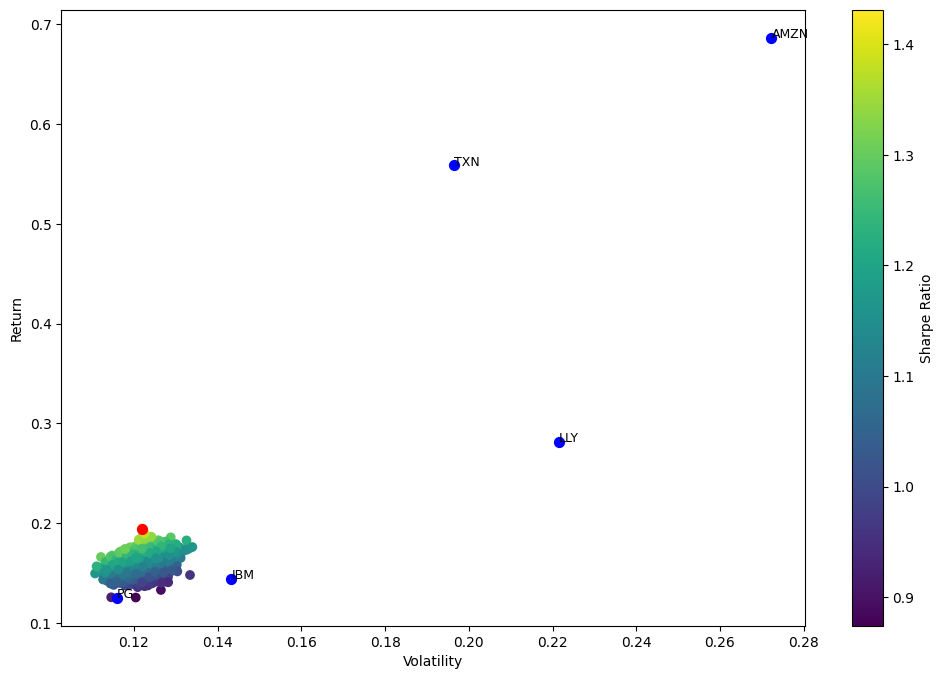

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# number of simulations
num_portfolios = 1000
risk_free_rate = 0.02  # assuming a risk-free rate of 1%
valid_tickers = valid_tickers
expected_returns = mu
covariance_matrix = S
optimized_weights = adjusted_weights
# pre-allocating space for each simulation's return and standard deviation
port_returns = np.zeros(num_portfolios)
port_volatility = np.zeros(num_portfolios)
sharpe_ratio = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    port_returns[i] = np.sum(expected_returns * weights)
    port_volatility[i] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio[i] = (port_returns[i] - risk_free_rate) / port_volatility[i]

plt.figure(figsize=(12, 8))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')

index_high_sharpe = np.argmax(sharpe_ratio)
plt.scatter(port_volatility[index_high_sharpe], port_returns[index_high_sharpe], c='red', s=50)



for index in tickers_to_buy_idx:
    ticker_name = valid_tickers[index]
    x = np.sqrt(S[ticker_name][ticker_name])
    y = exp_profits[index]
    plt.scatter(x, y, c='blue', s=50)
    plt.text(x, y, ticker_name, fontsize=9)



plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [279]:
print(portfolio_return(adjusted_weights, mu))
print(portfolio_volatility(adjusted_weights, S))

9.59622916186161
0.05066177710759178


In [283]:
mu

array([[ 0.6000572 ],
       [ 0.00328448],
       [ 0.24460852],
       [ 0.04439486],
       [ 0.15531322],
       [ 0.18533133],
       [ 0.04915312],
       [ 0.12223531],
       [ 0.21267194],
       [ 0.06521123],
       [-0.01302115],
       [ 0.08681719],
       [ 0.26876473],
       [ 0.27925998],
       [-0.06266544],
       [ 0.40393339],
       [ 0.07791322],
       [ 0.06647406],
       [ 0.39877872],
       [ 0.32789263],
       [ 0.1488702 ],
       [ 0.20966391],
       [-0.04255854],
       [-0.05606025],
       [-0.03997648],
       [ 0.10393165],
       [ 0.11601928],
       [-0.0164272 ],
       [ 0.05609233],
       [ 0.08287344],
       [-0.00815096],
       [ 0.12911717],
       [ 0.11104052],
       [ 0.01359091],
       [-0.00622627],
       [ 0.06269222],
       [ 0.00096797],
       [-0.01542905],
       [ 0.11238722],
       [ 0.13931198],
       [ 0.16965317],
       [ 0.15981081],
       [-0.02901215],
       [ 0.00319639],
       [ 0.10467948],
       [ 0